# Praca domowa nr 5
### Wojciech Celej

In [1]:
import numpy as np
import pandas as pd

import lightgbm
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import *
import shap

import seaborn as sns
import matplotlib.pyplot as plt

---

## 1. Odtworzenie modeli

In [2]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")
df.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Przygotowanie danych

Wybrane przeze mnie zmienne to:
* ilościowe: 
    - `time_from_rel_to_cohab` -  year_fraction_first_cohab - year_fraction_relstart, negreset to zero 
    - `w6_q24_length` - length of q24 how met answer in characters 
* jakościowe: 
    - `hcm2017q24_church` - met in or through church or religious organization
    - `hcm2017q24_btwn_I_sig_other` - significant other relationship  between intermediaries

In [3]:
features = ["time_from_rel_to_cohab", "w6_q24_length", "hcm2017q24_church", "hcm2017q24_btwn_I_sig_other", "S1"]

In [4]:
myDf = df.loc[:, features].dropna()
myDf = myDf.query("time_from_rel_to_cohab > 0")

In [5]:
myDf.loc[:,"hcm2017q24_church"] = myDf.loc[:,"hcm2017q24_church"].map({"yes": 1, "no": 0})
myDf.loc[:,"hcm2017q24_btwn_I_sig_other"] = myDf.loc[:,"hcm2017q24_btwn_I_sig_other"].map({"yes": 1, "no": 0})
myDf.loc[:,"S1"] = myDf.loc[:,"S1"].apply(lambda x: 1 if x.startswith("Yes") else 0).astype(np.int32)

In [6]:
myDf.describe()

,time_from_rel_to_cohab,w6_q24_length,hcm2017q24_church,hcm2017q24_btwn_I_sig_other,S1
count,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,2.062339,200.837784,0.063417,0.015531,0.768335
std,2.775628,253.214722,0.243764,0.123677,0.421987
min,0.083252,1.000000,0.000000,0.000000,0.000000
25%,0.500000,67.000000,0.000000,0.000000,1.000000
50%,1.166748,136.000000,0.000000,0.000000,1.000000
75%,2.583252,241.000000,0.000000,0.000000,1.000000
max,36.750000,3855.000000,1.000000,1.000000,1.000000


In [7]:
X = myDf.iloc[:, :4]
y = myDf.loc[:, "S1"]

# Standaryzacja zmiennych
X = (X - X.mean())/X.std()

### LightGBM

In [8]:
lgb_model = lightgbm.LGBMClassifier()
lgb_model.fit(X, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [9]:
y_pred = lgb_model.predict_proba(X)[:,1]
roc_auc_score(y, y_pred)

0.8837930273725242

### Regresja logistyczna

In [10]:
log_model = LogisticRegression(solver="newton-cg")
log_model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
y_pred = log_model.predict_proba(X)[:,1]
roc_auc_score(y, y_pred)

0.592835924830379

---

## 2. Określenie ważności zmiennych

### a) Permutation based feature importance

Dla każdej zmiennej dokonano 100 losowych permutacji. Jako funkcji straty użyto funkcji *cross-entropy*. Użycie *accuracy score* jest niewskazane, ponieważ klasy są niezbilansowane (na korzyść klasy 1), co powoduje, że bez odpowiedniego dostrojenia modelu regresja logistyczna wszystkie obserwacje klasyfikuje jako 1

In [12]:
def permutation_based_feature_importance(model, x_train, y_true, draw = True):
    feature_importances = pd.DataFrame(columns=["feature", "logloss_drop"])
    y_pred = model.predict_proba(x_train)
    original_log_loss = log_loss(y_true, y_pred)
    for it, column in enumerate(x_train.columns):
        num_iter = 100
        mod_log_loss = 0
        for i in range(num_iter):
            modified_x = x_train.copy()
            modified_x[column] = np.random.permutation(x_train[column])
            y_pred_mod = model.predict_proba(modified_x)
            mod_log_loss += log_loss(y_true, y_pred_mod)
        mod_log_loss /= num_iter
        feature_importances.loc[it] = [column, mod_log_loss - original_log_loss]
    if draw:
        sns.set(rc={'figure.figsize':(8,3)}, style="whitegrid")
        sns.barplot(data = feature_importances, x = "logloss_drop", y="feature", color="#208ce4", 
                    order=feature_importances.sort_values("logloss_drop", ascending=False)["feature"])
        plt.title("Permutation based feature importance", size = 16)
        plt.ylabel("")
        plt.xlabel("Loss-drop after perturbations", size = 14)
    return feature_importances

#### LightGBM

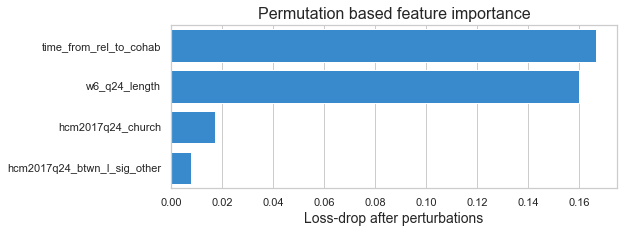

In [13]:
fi = permutation_based_feature_importance(lgb_model, X, y)

#### Regresja logistyczna

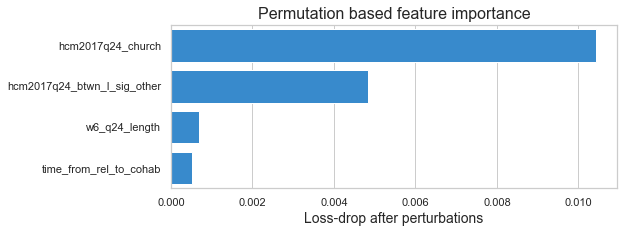

In [14]:
fi = permutation_based_feature_importance(log_model, X, y)

### b) Model specific feature importance

In [15]:
def model_specific_feature_importance(features, values):
    feature_importances = pd.DataFrame({"feature": features, "values": values})
    sns.set(rc={'figure.figsize':(8,3)}, style="whitegrid")
    sns.barplot(data = feature_importances, x = "values", y="feature", color="#208ce4", order=feature_importances.sort_values("values", ascending=False)["feature"])
    plt.title("Model specific feature importance", size = 16)
    plt.ylabel("")
    plt.xlabel("coef")

#### LightGBM

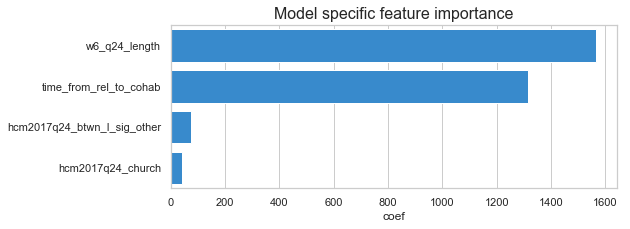

In [16]:
model_specific_feature_importance(X.columns, lgb_model.feature_importances_)

#### Regresja logistyczna

Dane treningowe zostały ustandaryzowane, stąd wartości współczynników są miarodajne

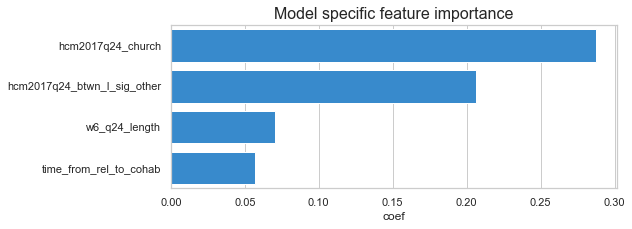

In [17]:
model_specific_feature_importance(X.columns, log_model.coef_.flatten())

### *c) Shap

In [18]:
lgb_explainer = shap.TreeExplainer(lgb_model)
lgb_shap_values = lgb_explainer.shap_values(X)

log_explainer = shap.LinearExplainer(log_model, X, feature_dependence="correlation")
log_shap_values = log_explainer.shap_values(X)

Estimating transforms: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3117.21it/s]


#### LightGBM

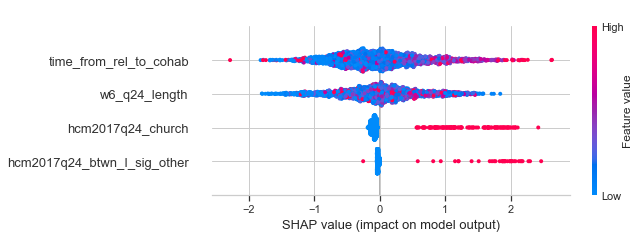

In [19]:
shap.summary_plot(lgb_shap_values, X)

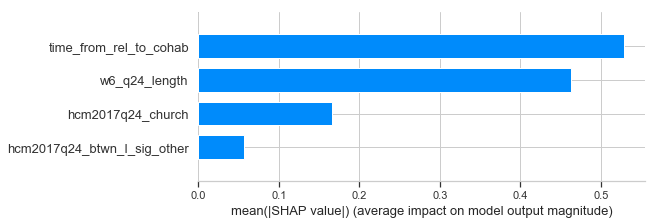

In [20]:
shap.summary_plot(lgb_shap_values, X, plot_type="bar")

#### Regresja logistyczna

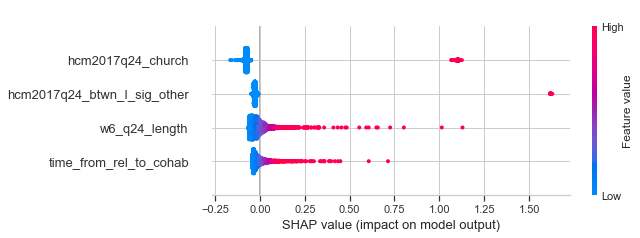

In [21]:
shap.summary_plot(log_shap_values, X)

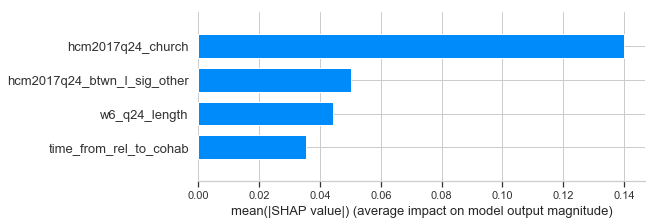

In [22]:
shap.summary_plot(log_shap_values, X, plot_type="bar")

---

## 3. Porównanie ważności zmiennych dla dwóch modeli

### Wykres porównujący ważność zmiennych dla dwóch modeli metodą perturbacji zmiennej

In [23]:
def compare_models_by_permutation(model1, model2, x_train, y_true):
    feature_importances_mod1 = permutation_based_feature_importance(model1, x_train, y_true, draw = False)
    feature_importances_mod1["model"] = type(model1).__name__
    feature_importances_mod2 = permutation_based_feature_importance(model2, x_train, y_true, draw = False)
    feature_importances_mod2["model"] = type(model2).__name__
    feature_importances = feature_importances_mod1.append(feature_importances_mod2, ignore_index=True)
    
    sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")
    sns.barplot(data = feature_importances, x = "logloss_drop", y="feature", palette = "Paired",
                order=feature_importances_mod1.sort_values("logloss_drop", ascending=False)["feature"], hue = "model")
    plt.title("Permutation based feature importance", size = 16)
    plt.ylabel("")
    plt.xlabel("Loss-drop after perturbations", size = 14)

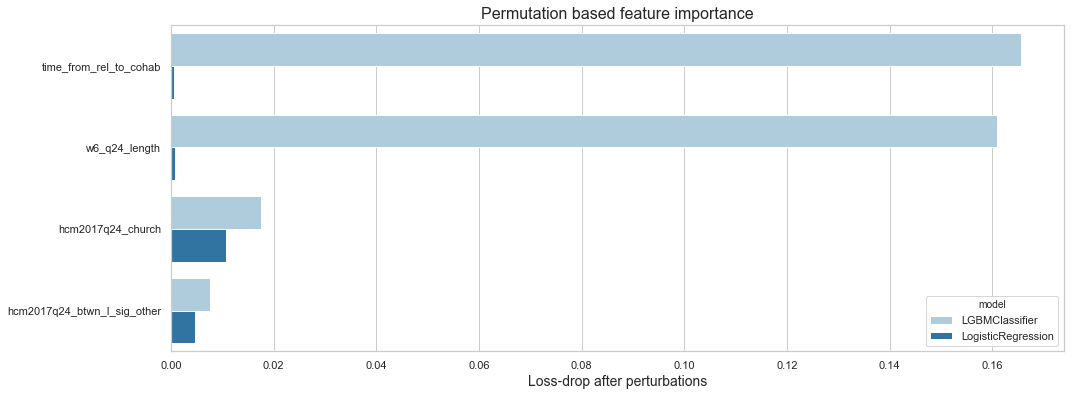

In [24]:
compare_models_by_permutation(lgb_model, log_model, X, y)

### Wykres porównujący ważność zmiennych dla dwóch modeli według danego modelu

In [25]:
def model_specific_feature_importance(features, model1_values, model2_values, model1_name, model2_name):
    model1_values_norm = model1_values / np.linalg.norm(model1_values)
    model2_values_norm = model2_values / np.linalg.norm(model2_values)
    feature_importances_mod1 = pd.DataFrame({"feature": features, "values": model1_values_norm, "model": model1_name})
    feature_importances_mod2 = pd.DataFrame({"feature": features, "values": model2_values_norm, "model": model2_name})
    feature_importances = feature_importances_mod1.append(feature_importances_mod2, ignore_index=True)
    
    sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")
    sns.barplot(data = feature_importances, x ="values", y="feature", palette = "Paired",
                order=feature_importances_mod1.sort_values("values", ascending=False)["feature"], hue = "model")
    plt.title("Model Specific feature importance", size = 16)
    plt.ylabel("")
    plt.xlabel("Importance", size = 14)

Wartości te zostały znormalizowane, celem przedstawienia ich na jednorodnej skalu

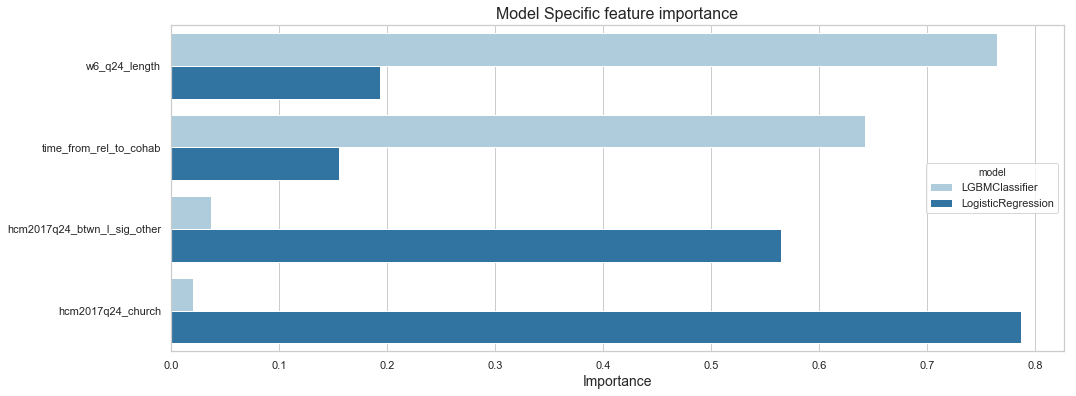

In [26]:
model_specific_feature_importance(X.columns, lgb_model.feature_importances_, log_model.coef_.flatten(), "LGBMClassifier", "LogisticRegression")

### Tabela pozycji pod względem ważności dla klasyfikatora LightGBM:

|Zmienna\Metoda|Permutation based|Shap|Model specific|
|---|---|---|---|
|`time_from_rel_to_cohab`|1|1|2|
|`w6_q24_length`|2|2|1|
|`hcm2017q24_church`|3|3|4|
|`hcm2017q24_btwn_I_sig_other`|4|4|3|

### Tabela pozycji pod względem ważności dla regresji logistycznej:

|Zmienna\Metoda|Permutation based|Shap|Model specific|
|---|---|---|---|
|`time_from_rel_to_cohab`|4|4|4|
|`w6_q24_length`|3|3|3|
|`hcm2017q24_church`|1|1|1|
|`hcm2017q24_btwn_I_sig_other`|2|2|2|

### Wnioski

* Ważności zmiennych w modelach LightGBM i regresji logistycznej wyliczone metodą perturbacji zmiennych różnią się diametralnie. I tak:
    * `time_from_rel_to_cohab` - dla LightGBM jest najważniejsza, a dla regresji logistycznej najmniej ważna
    * `w6_q24_length` - dla LightGBM jest 2. pod względem ważności, a dla regresji logistycznej 2. od końca
    * `hcm2017q24_church` - dla LightGBM 2. od końca pod względem ważności, a dla regresji logistycznej najważniejsza
    * `hcm2017q24_btwn_I_sig_other` - dla LightGBM najmniej ważna, a dla regresji logistycznej 2. pod wzlęgem ważności
* Można mówić wręcz o odwróceniu kolejności.
* Co ważne, wyjaśnienie uzyskane metodą SHAP pokrywa się z metodą permutacji zmiennej. Wyjaśnienie *model specific* pokrywa się dla regresji logistycznej, a dla LightGBM 1. zamienia się z 2., a 3. z 4.
* To co odnotowano w obud modelach, zwłaszcza dla metody permutacji zmiennej oraz dla wyjaśnienia *model specific*, to fakt, że dwie najistotniejsze zmienne są dużo bardziej istotne, niż dwie najmniej istotne zmienne.
* Zmienne binarne są znacznie istotniejsze dla regresji logistycznej.
* Zmienne liczbowe są znacznie istotniejsze dla LightGBM.
* Zmienną która najbardziej różni porównywane modele jest `time_from_rel_to_cohab`.

---

## 4. Krzywe PDP i ALEplot dla zmiennej najbardziej różniącej porównywane modele

In [27]:
def plot_dp(model, df, feature, nPoints, ax):
    featureRange = (df.loc[:, feature].min(), df.loc[:, feature].max())
    x = np.linspace(featureRange[0], featureRange[1], num=nPoints, endpoint=True)
    y_cum = []
    for index, row in df.iterrows():
        sample = pd.DataFrame(columns=row.index)
        sample.loc[0] = row.values
        samples = sample.append([sample.iloc[0, :]]*(nPoints-1), ignore_index=True).reset_index(drop=True)
        samples.loc[:, feature] = x
        y = model.predict_proba(samples)[:,1]
        y_cum.append(y)
        ax.plot(x, y, color="gray", linewidth=0.5, alpha = 0.4)
        sample_x = sample.loc[:, feature]
        sample_prob = model.predict_proba(sample)[:,1]
        ax.plot(sample_x, sample_prob, "o", markersize=3, color="black", alpha=0.6)
    y_cum = np.array(y_cum).mean(axis=0)
    ax.plot(x, y_cum, color="navy", linewidth=5)
    ax.set_ylabel("Married probability")
    ax.set_ylim(0,1)
    ax.set_title("PDP")
    return x, y_cum

In [28]:
def plot_ale(model, df, feature, ax, plot=True):
    quantile = df[feature].quantile(np.linspace(0.005, 1, 200))
    x_vect = []
    y_vect = []
    
    prev_x = df[feature].min()
    next_x = quantile.iloc[0]
    samples = df.loc[(df[feature] >= prev_x) & (df[feature] <= next_x)]
    n_samples = samples.shape[0]
    y_upper = 0
    y_bottom = 0
    for index, row in samples.iterrows():
        sample = pd.DataFrame(columns=row.index)
        sample.loc[0] = row.values
        sample.loc[1] = row.values
        sample.loc[0, feature] = prev_x
        sample.loc[1, feature] = next_x
        y = model.predict_proba(sample)[:,1]
        y_upper += y[1]
        y_bottom += y[0]
    if n_samples > 0:
        acc_effect = (y_upper - y_bottom) / n_samples
    else:
        acc_effect = 0
    x_value = (prev_x + next_x) / 2
    x_vect.append(x_value)
    y_vect.append(acc_effect)
    prev_x = next_x

    for next_x in quantile.iloc[1:]:
        samples = df.loc[(df[feature] > prev_x) & (df[feature] <= next_x)]
        n_samples = samples.shape[0]
        if n_samples == 0:
            continue
        y_upper = 0
        y_bottom = 0
        for index, row in samples.iterrows():
            sample = pd.DataFrame(columns=row.index)
            sample.loc[0] = row.values
            sample.loc[1] = row.values
            sample.loc[0, feature] = prev_x
            sample.loc[1, feature] = next_x
            y = model.predict_proba(sample)[:,1]
            y_upper += y[1]
            y_bottom += y[0]
        acc_effect = (y_upper - y_bottom) / n_samples       
        x_value = (prev_x + next_x) / 2
        x_vect.append(x_value)
        y_vect.append(acc_effect)
        prev_x = next_x
    
    x_vect = np.array(x_vect)
    y_vect = np.array(y_vect)
    y_vect = y_vect.cumsum()
    y_vect = y_vect - y_vect.mean()
    
    if plot:
        ax.plot(x_vect, y_vect, color="darkred")
        ax.set_title("ALE plot")
        ax.set_ylabel("ALE values")
        
    return x_vect, y_vect

In [29]:
def compare_plots(model, X, feature):
    sns.set(rc={'figure.figsize':(15,12)})
    sns.set_style("darkgrid")
    sns.set_context("paper")
    fig, axes = plt.subplots(2, 1)
    plot_dp(model, X, feature, 100, axes[0])
    plot_ale(model, X, feature, axes[1])
    axes[0].set_xlim(axes[1].get_xlim())
    axes[1].set_xlabel(feature)

### Wykresy dla modelu LightGBM

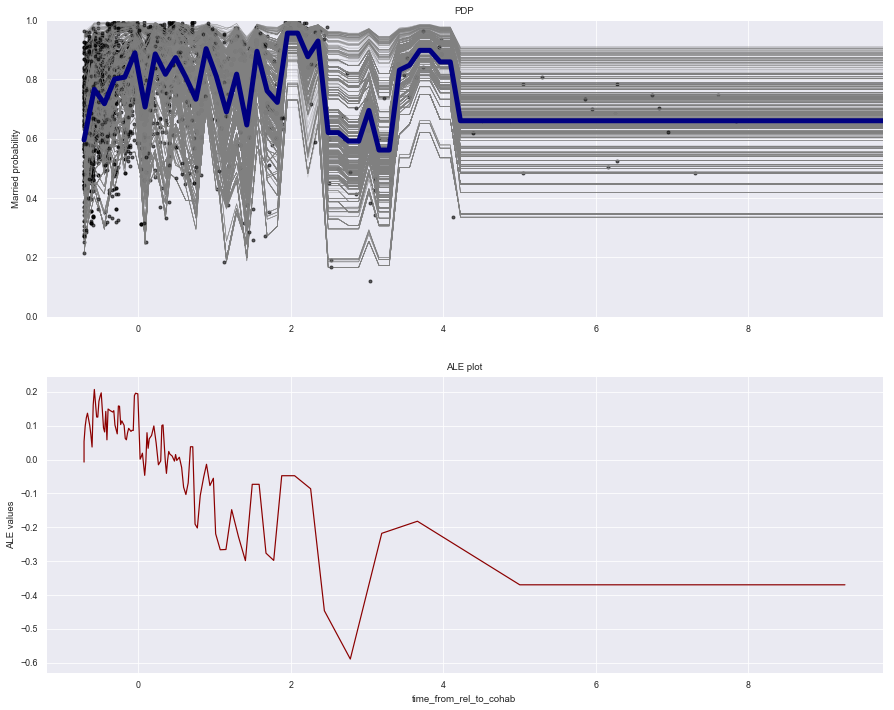

In [30]:
compare_plots(lgb_model, X, "time_from_rel_to_cohab")

### Wykresy dla modelu regresji logistycznej

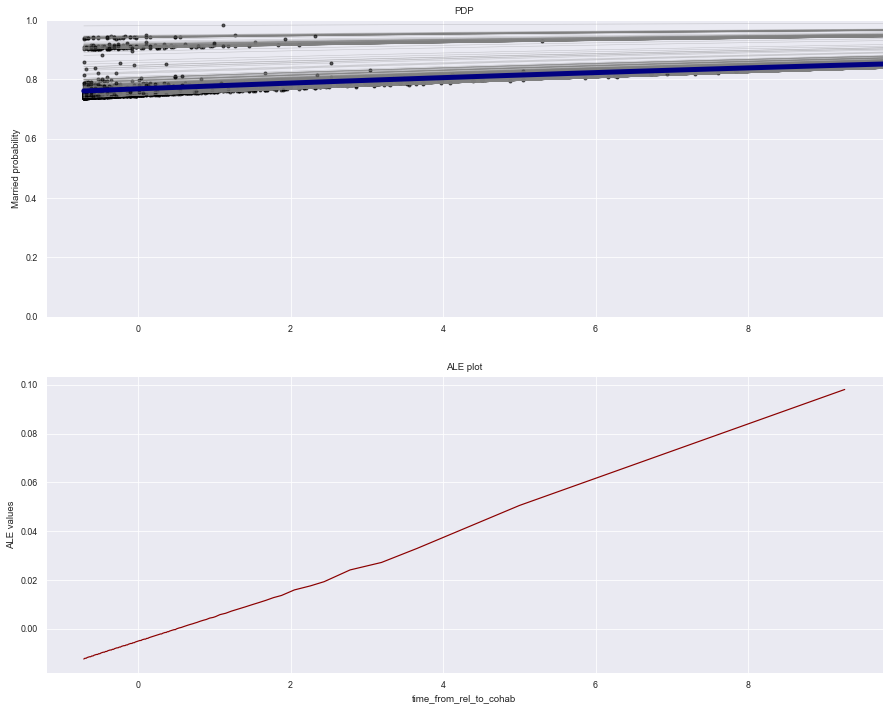

In [31]:
compare_plots(log_model, X, "time_from_rel_to_cohab")

### Wykres ALE dla jednej cechy porównujący modele

In [32]:
def compare_ale(model1, model2, df, feature):
    sns.set(rc={'figure.figsize':(15,8)})
    sns.set_style("darkgrid")
    sns.set_context("paper")
    x1, y1 = plot_ale(model1, df, feature, ax=None, plot=False)
    x2, y2 = plot_ale(model2, df, feature, ax=None, plot=False)
    plt.plot(x1, y1, linewidth=2)
    plt.plot(x2, y2, linewidth=2)
    plt.title("ALE comparison between models")
    plt.xlabel(feature)
    plt.ylabel("ALE values")
    plt.legend([type(model1).__name__, type(model2).__name__], loc='lower right')

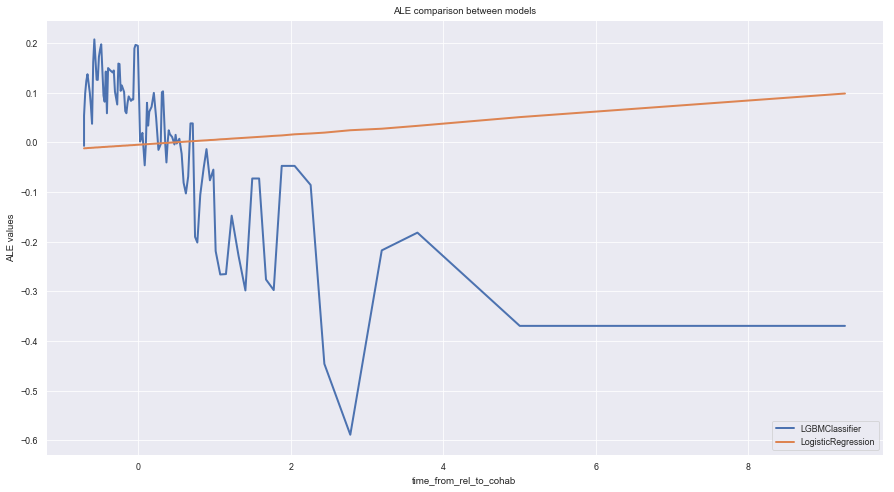

In [33]:
compare_ale(lgb_model, log_model, X, "time_from_rel_to_cohab")

### Wnioski
* Zmienna `time_from_rel_to_cohab` jest zmienną numeryczną. Wpływ tej zmiennej na model regresji logistycznej jest niewielki (krzywe są prawie poziome). Może wynikać to z faktu, że regresja logistyczna jest modelem  liniowym, niezdolnym wychwycić silne zależności nielinowe dle tej zmiennej.
* Z kolei, co widać na wykresach PDP i ALE dla modelu złożonego jakim jest LightGBM, zależności dla tej zmiennej są mocno nieliniowe (wartości predykcji mocno fluktuują w konkretnych przedziałach). 
* Dla obu modeli różni się też linia trendu.
* Różnice dla tej zmiennej najpewniej wynikają z ograniczeń modelu regresji logistycznej.